# Steps to solve Emergency vs Non-Emergency vehicle classification problem

<ol>1. Import necessary libraries</ol>
<ol>2. Loading the Dataset</ol>
<ol>3. Pre-processing the Data</ol>
<ol>4. Load weights of pretrained model</ol>
<ol>5. Fine tune the model for the current problem</ol>
<ol>6. Validate if it works fine, iterate again if it does not</ol>

## 1. Import necessary libraries

In [1]:
# importing the required libraries
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# importing libraries for defining the architecture of model
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import Linear, ReLU, BCELoss, Sequential, Sigmoid

# import torchvision
from torchvision.models import vgg16
from torchvision.models import resnet50


**Notes**

We can use already trained model on similar task to train our model.

Eg. Pretrained VGG16 model used to classify vehicle.

**Different ways of tunning**

1. Use pretrained model as fixed feature extractor to solve current problem.
(Simple but not best way)
2. Use architecture of pretrained model but train it on current dataset from scratch. (Time taking training process)
3. Freeze initial layers of pretrained model and train last layers.


Here we are going to use pretrained model as feature extractor.

**Torchvision**
It is package compatible with pytorch.

It consists of many popular datasets, architectures along with pretrained weights and common image transformations.

We need to install this package in local system.

Eg:

!pip install torchvision

from torchvision.models import vgg16

**Use of pretrained model as feature extractor:**

1. Download pretrained model with frozen weights.

2. Pass all images through models and saves extracted features for each image as output.

3. Flatten these feature maps of each image.

4. Build neural network and train it on these feature maps for prediction.

## 2. Loading the Dataset

In [2]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#extract the images
!unzip '/content/drive/MyDrive/Omkar/Deep_learning/Dataset.zip'

Archive:  /content/drive/MyDrive/Omkar/Deep_learning/Dataset.zip
   creating: Dataset/
  inflating: Dataset/emergency_classification.csv  
   creating: Dataset/images/
  inflating: Dataset/images/1002.jpg  
  inflating: Dataset/images/1007.jpg  
  inflating: Dataset/images/102.jpg  
  inflating: Dataset/images/1023.jpg  
  inflating: Dataset/images/1036.jpg  
  inflating: Dataset/images/104.jpg  
  inflating: Dataset/images/1040.jpg  
  inflating: Dataset/images/1046.jpg  
  inflating: Dataset/images/1047.jpg  
  inflating: Dataset/images/1050.jpg  
  inflating: Dataset/images/1052.jpg  
  inflating: Dataset/images/1062.jpg  
  inflating: Dataset/images/1075.jpg  
  inflating: Dataset/images/1076.jpg  
  inflating: Dataset/images/1079.jpg  
  inflating: Dataset/images/1081.jpg  
  inflating: Dataset/images/109.jpg  
  inflating: Dataset/images/1097.jpg  
  inflating: Dataset/images/1103.jpg  
  inflating: Dataset/images/1108.jpg  
  inflating: Dataset/images/1112.jpg  
  inflating: Dat

In [7]:
#reading a csv file
data = pd.read_csv('Dataset/emergency_classification.csv')


In [8]:
# creating a random seed
seed = 42

In [9]:
#first 5 rows
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [10]:
# load images and store it in numpy array

# empty list to store the images
X = []

# iterating over each image
for img_name in data.image_names:

    # loading the image using its name
    img = plt.imread('Dataset/images/' + img_name)

    # normalizing the pixel values
    img = img / 255.

    # saving each image in the list
    X.append(img)

# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

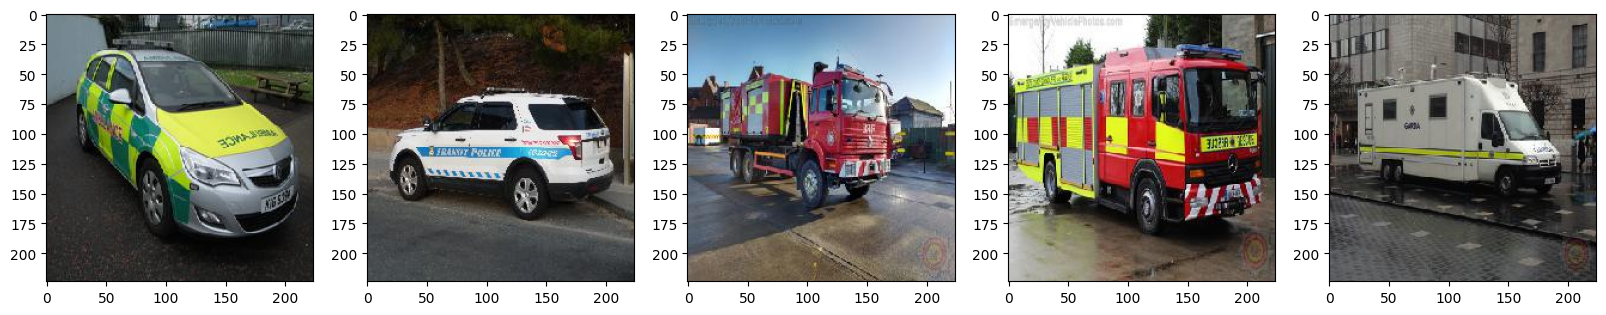

In [11]:
#Glance at the images
fig, axes = plt.subplots(ncols=5,figsize=(20,10))
for i in range(5):
  axes[i].imshow(X[i])

## 3. Pre-processing the Data

In [12]:
#shape of the image
X.shape

(2352, 224, 224, 3)

In [13]:
#reshaping array
X = np.moveaxis(X, -1, 1)
X.shape

(2352, 3, 224, 224)

In [14]:
#converting array to tensor
X = torch.FloatTensor(X)

In [15]:
#data type
type(X)

torch.Tensor

# ResNet 50 unfreezed


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

class TensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16, shuffle=False)


In [25]:
import torch.nn as nn
from torchvision.models import resnet50

class ResNet50Custom(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        base_model = resnet50(pretrained=True)

        # 🔒 Freeze all layers
        for param in base_model.parameters():
            param.requires_grad = False

        # 🔓 Unfreeze last 2 blocks
        for param in base_model.layer3.parameters():
            param.requires_grad = True
        for param in base_model.layer4.parameters():
            param.requires_grad = True

        self.backbone = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool,
            base_model.layer1,
            base_model.layer2,
            base_model.layer3,
            base_model.layer4,
            base_model.avgpool
        )

        # 🔹 3 Fully Connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(set(y))   # or manually set
model = ResNet50Custom(num_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [27]:
best_val_loss = float("inf")

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # 🔍 Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")

    # 💾 Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print("✅ Best model saved")


Epoch [1/150] Train Loss: 0.2626 Val Loss: 0.1004 Val Acc: 0.9660
✅ Best model saved
Epoch [2/150] Train Loss: 0.0934 Val Loss: 0.1325 Val Acc: 0.9554
Epoch [3/150] Train Loss: 0.0315 Val Loss: 0.1345 Val Acc: 0.9533
Epoch [4/150] Train Loss: 0.0397 Val Loss: 0.1350 Val Acc: 0.9554
Epoch [5/150] Train Loss: 0.0397 Val Loss: 0.1183 Val Acc: 0.9618
Epoch [6/150] Train Loss: 0.0360 Val Loss: 0.1438 Val Acc: 0.9533
Epoch [7/150] Train Loss: 0.0198 Val Loss: 0.1884 Val Acc: 0.9512
Epoch [8/150] Train Loss: 0.0393 Val Loss: 0.1784 Val Acc: 0.9512
Epoch [9/150] Train Loss: 0.0338 Val Loss: 0.1653 Val Acc: 0.9618
Epoch [10/150] Train Loss: 0.0123 Val Loss: 0.1595 Val Acc: 0.9533
Epoch [11/150] Train Loss: 0.0162 Val Loss: 0.1571 Val Acc: 0.9490
Epoch [12/150] Train Loss: 0.0694 Val Loss: 0.2331 Val Acc: 0.9469
Epoch [13/150] Train Loss: 0.0261 Val Loss: 0.1173 Val Acc: 0.9618
Epoch [14/150] Train Loss: 0.0071 Val Loss: 0.1450 Val Acc: 0.9575
Epoch [15/150] Train Loss: 0.0047 Val Loss: 0.1569 V

# Testing Pileline

In [28]:
from torchvision import transforms
from PIL import Image

# adjust size if needed (ResNet expects 224x224)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [29]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_image(image_path, model):
    """
    image_path: path to image file
    model: trained PyTorch model
    """

    # load image
    image = Image.open(image_path).convert("RGB")

    # preprocess
    image = inference_transform(image)

    # add batch dimension
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()

    return pred


In [30]:
class_names = ["Emergency", "Non-emergency"]

def predict_image_label(image_path, model):
    idx = predict_image(image_path, model)
    return class_names[idx]


In [31]:
import torch.nn.functional as F

def predict_image_with_confidence(image_path, model):
    image = Image.open(image_path).convert("RGB")
    image = inference_transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(image)
        probs = F.softmax(logits, dim=1)
        conf, pred = torch.max(probs, dim=1)

    return pred.item(), conf.item()


In [33]:
loaded_model = ResNet50Custom(num_classes).to(device)
loaded_model.load_state_dict(torch.load("/content/best_resnet50_model.pth"))

predict_image_with_confidence('/content/ambulance.jpeg', loaded_model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(1, 0.9935247898101807)